In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve
)
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import tree
%matplotlib inline

In [58]:
#load dataset
df = pd.read_csv('IRIS.csv')
print('\n no of rows and columns', df.shape)
# print few rows
df.head()


 no of rows and columns (129, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [59]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


In [60]:
#check number of classes in label
pd.unique(df['species'])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [61]:
# Preprocessing
# Encode target variable
if df['species'].dtype == 'object':
    le = LabelEncoder()
    df['species'] = le.fit_transform(df['species'])

In [62]:
#check encoded classes
pd.unique(df['species'])

array([0, 1, 2])

In [63]:
#check for dataset imbalance
print('number of samples in each class:')
df['species'].value_counts()

number of samples in each class:


species
0    50
1    50
2    29
Name: count, dtype: int64

In [64]:
#balancing dataset
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['species']), y=df['species'])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df['species']), class_weights)}

# Compute sample weights for each instance
sample_weights = compute_sample_weight(class_weight=class_weights_dict, y=df['species'])

In [65]:
X = df.drop('species', axis=1)
y = df['species']
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
# Train-test split
X_train, X_test, y_train, y_test, y1_train, y1_test = train_test_split(X_scaled, y, sample_weights, test_size=0.3, stratify=y, random_state=42)

In [67]:
# Assisgnment: perform exploratory data analysis using decriptive statistics and different plot. oNote down and Discuss
X.info()
X.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  129 non-null    float64
 1   sepal_width   129 non-null    float64
 2   petal_length  129 non-null    float64
 3   petal_width   129 non-null    float64
dtypes: float64(4)
memory usage: 4.2 KB


,sepal_length,sepal_width,petal_length,petal_width
count,129.000000,129.000000,129.000000,129.000000
mean,5.716279,3.057364,3.476744,1.062791
std,0.794983,0.453075,1.739231,0.727804
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.500000,0.200000
50%,5.600000,3.000000,4.000000,1.200000
75%,6.300000,3.400000,4.800000,1.600000
max,7.700000,4.400000,6.900000,2.500000


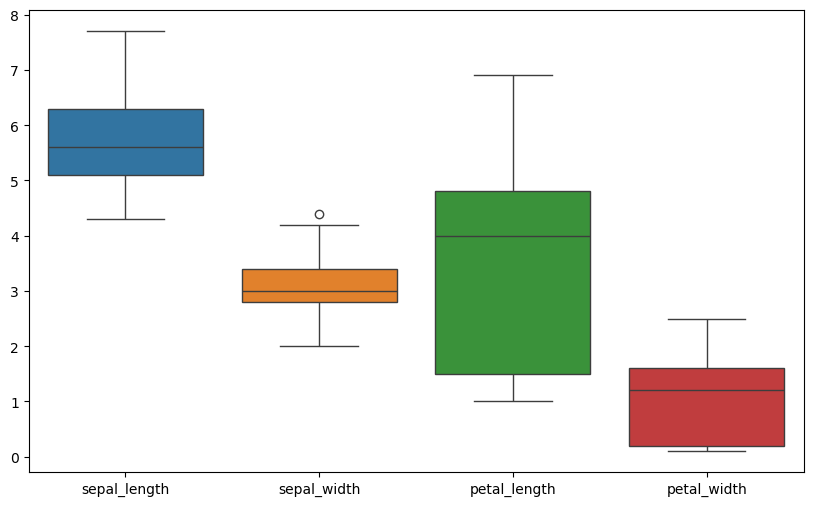

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.show()

In [69]:
#sepal length is almost normal distributed, sepal with has one outlier, petal length has the widest range and skewed distribution, petal width is skewed distributed

In [70]:
# Multi-Class Classification without dataset balancing
# Logistic Regression (One-vs-Rest)
lr_ovr = OneVsRestClassifier(LogisticRegression())
lr_ovr.fit(X_train, y_train)
y_pred_lr_ovr = lr_ovr.predict(X_test)

print("\nLogistic Regression (One-vs-Rest) Performance:")
print(classification_report(y_test, y_pred_lr_ovr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_ovr))


Logistic Regression (One-vs-Rest) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]


In [71]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

In [72]:
# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
clf.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf.fit(X_train, y_train, sample_weight=y1_train)
y_pred = clf.predict(X_test)

# Classification Report and Confusion Matrix
print("\nLogistic Regression (One-vs-Rest) Performance balanced weights:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression (One-vs-Rest) Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.60      0.75        15
           2       0.60      1.00      0.75         9

    accuracy                           0.85        39
   macro avg       0.87      0.87      0.83        39
weighted avg       0.91      0.85      0.85        39

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  0  9]]


In [73]:
lr_ovo = OneVsOneClassifier(LogisticRegression())
lr_ovo.fit(X_train, y_train)
y_pred_lr_ovo = lr_ovo.predict(X_test)

print("\nLogistic Regression (One-vs-One) Performance:")
print(classification_report(y_test, y_pred_lr_ovo))


Logistic Regression (One-vs-One) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



In [74]:
softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax.fit(X_train, y_train)
y_pred_softmax = softmax.predict(X_test)

print("\nSoftmax Regression Performance:")
print(classification_report(y_test, y_pred_softmax))


Softmax Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [75]:
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        print("Log Loss:", log_loss(y_true, y_proba))
        print("ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))

In [76]:
# Evaluate Logistic Regression (OvR)
evaluate_model(y_test, y_pred_lr_ovr, lr_ovr.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Log Loss: 0.31997430412578065
ROC AUC Score (OvR): 0.9817901234567902


In [77]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Performance:")
evaluate_model(y_test, y_pred_dt, dt.predict_proba(X_test))


Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9241962407465939
ROC AUC Score (OvR): 0.9745370370370371


In [78]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

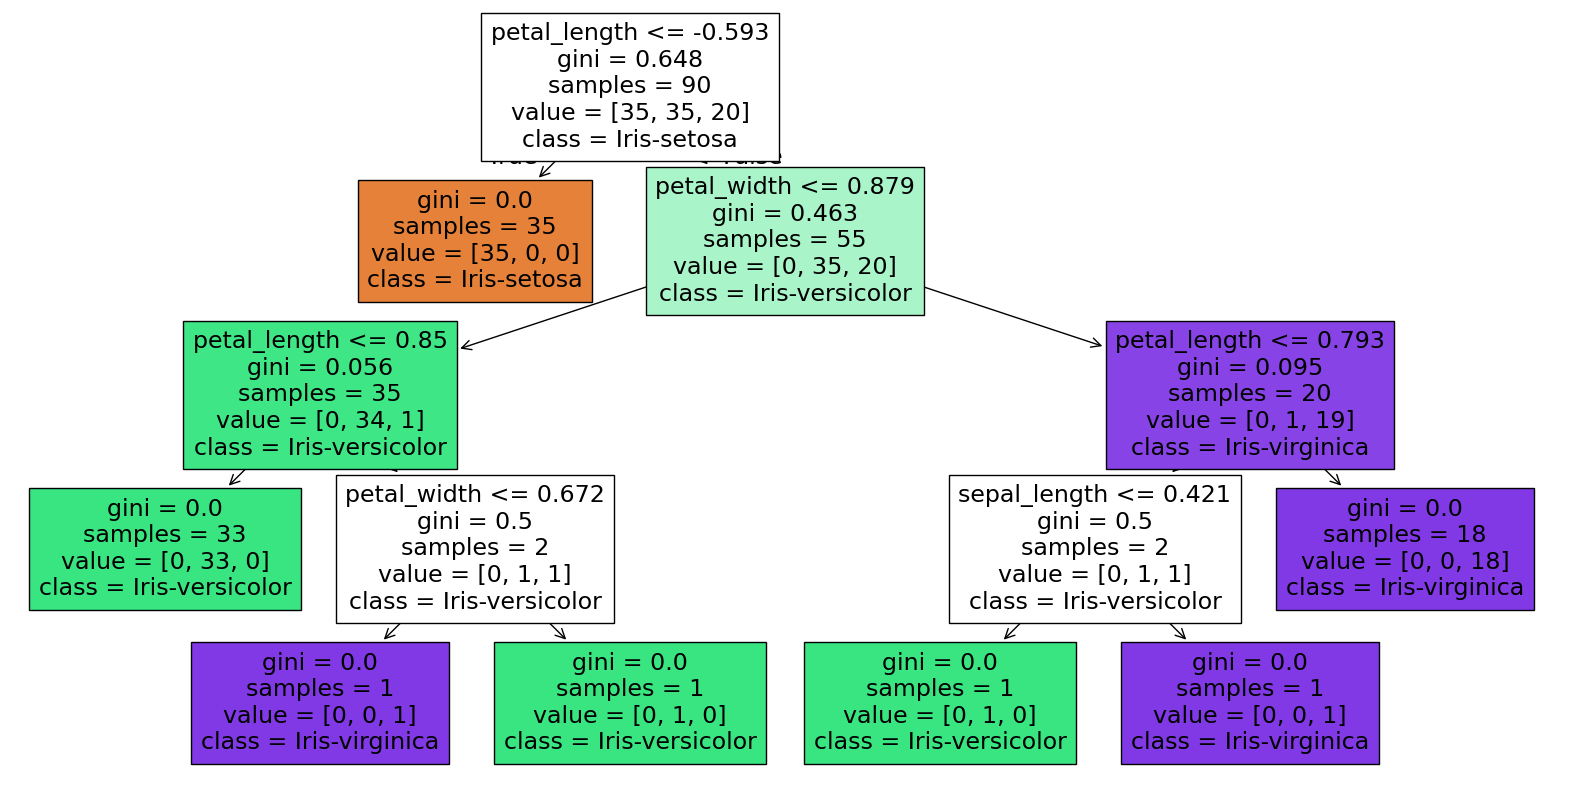

In [79]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

In [80]:
# Hyperparameter Tuning (Decision Tree)
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Decision Tree:")
print(grid_search.best_params_)
#Best Parameters for Decision Tree:
#{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Evaluate tuned Decision Tree
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

print("\nTuned Decision Tree Performance:")
evaluate_model(y_test, y_pred_best_dt, best_dt.predict_proba(X_test))


Best Parameters for Decision Tree:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuned Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9419692453763361
ROC AUC Score (OvR): 0.9734567901234569


In [81]:
#Assignment: try all the other models with balancing the dataset using weights and note down the findings
#plot confusion matrices for all models
models = {
    'Logistic Regression (OvR)': lr_ovr,
    'Logistic Regression (OvO)': lr_ovo,
    'Softmax Regression': softmax,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name,'\n', confusion_matrix( y_test, y_pred, sample_weight=y1_test))

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred, sample_weight=y1_test),
            'Precision': precision_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'Recall': recall_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'F1': f1_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred, sample_weight=y1_test),
            'Precision': precision_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'Recall': recall_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'F1': f1_score(y_test, y_pred, sample_weight=y1_test, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba, sample_weight=y1_test),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, sample_weight=y1_test, multi_class='ovr'),
            
        })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df

Logistic Regression (OvR) 
 [[12.9         0.          0.        ]
 [ 0.         11.18        1.72      ]
 [ 0.          1.48275862 11.86206897]]
Logistic Regression (OvO) 
 [[12.9         0.          0.        ]
 [ 0.         12.9         0.        ]
 [ 0.          1.48275862 11.86206897]]
Softmax Regression 
 [[12.9         0.          0.        ]
 [ 0.         12.9         0.        ]
 [ 0.          1.48275862 11.86206897]]
Decision Tree 
 [[12.9         0.          0.        ]
 [ 0.         12.9         0.        ]
 [ 0.          1.48275862 11.86206897]]
Random Forest 
 [[12.9         0.          0.        ]
 [ 0.         12.04        0.86      ]
 [ 0.          1.48275862 11.86206897]]
Gradient Boosting 
 [[12.9         0.          0.        ]
 [ 0.         12.9         0.        ]
 [ 0.          1.48275862 11.86206897]]

Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.918182,0.918240,0.918182,0.918163,0.340179,0.97856
1,Logistic Regression (OvO),0.962121,0.966026,0.962121,0.962036,Not Available,Not Available
2,Softmax Regression,0.962121,0.966026,0.962121,0.962036,0.164449,1.0
3,Decision Tree,0.962121,0.966026,0.962121,0.962036,1.36529,0.972065
4,Random Forest,0.940152,0.940820,0.940152,0.940142,0.107315,0.99751
5,Gradient Boosting,0.962121,0.966026,0.962121,0.962036,0.507376,0.970119


In [82]:
# Model Comparison
models = {
    'Logistic Regression (OvR)': lr_ovr,
    'Logistic Regression (OvO)': lr_ovo,
    'Softmax Regression': softmax,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, multi_class='ovr')
        })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.923077,0.926374,0.923077,0.923775,0.319974,0.98179
1,Logistic Regression (OvO),0.974359,0.975962,0.974359,0.974018,Not Available,Not Available
2,Softmax Regression,0.974359,0.975962,0.974359,0.974018,0.15615,1.0
3,Decision Tree,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537
4,Random Forest,0.948718,0.948718,0.948718,0.948718,0.083622,0.99784
5,Gradient Boosting,0.974359,0.975962,0.974359,0.974018,0.343461,0.974074
